# Fraudulent Transaction Detection

E-commerce websites often transact huge amounts of money. Whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, laundering money, etc. 

**Goal:** To build a machine learning model for an e-commerce company that predicts the probability that the first transaction of a new user is fraudulent.

**Constrains:** 

1- Incorrectly flagging a real transaction as fraudulent (False Alarm Cost): $8.00  
2- Failing to identify a fraudulent transaction (Fraud Loss): Average product values  


### Datasets:
#### Note: Dataset is not included.


1- **fraud.csv** information about each user first transaction.  
2- **IpAddress_to_Country.csv** list of countries' IP ranges

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Path to datasets
DATA_PATH = './dataset/fraud.csv'
IP_TABLE_PATH = './dataset/IpAddress_to_Country.csv'

# Read data
ip_df = pd.read_csv(IP_TABLE_PATH)
data_df = pd.read_csv(DATA_PATH,
                      parse_dates=['signup_time', 'purchase_time'],
                      index_col=0)

In [3]:
# Check feature types
data_df.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

In [4]:
# check feature types
ip_df.dtypes

lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object

In [5]:
data_df.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [6]:
ip_df.head(5)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
# Check numerical features
data_df.describe()

,user_id,purchase_value,age,ip_address,class
count,120000.000000,120000.000000,120000.000000,1.200000e+05,120000.000000
mean,200320.280100,36.881475,33.125250,2.151550e+09,0.093875
std,115361.945935,18.325855,8.617081,1.248314e+09,0.291656
min,2.000000,9.000000,18.000000,9.344714e+04,0.000000
25%,100925.500000,22.000000,27.000000,1.085345e+09,0.000000
50%,200037.500000,34.000000,33.000000,2.155238e+09,0.000000
75%,300395.500000,49.000000,39.000000,3.241268e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [8]:
# Check other features
data_df.describe(exclude='number')

# Note: count(device_id) = 120000
#       unique(device_id) = 110599
#       no missing values

,signup_time,purchase_time,device_id,source,browser,sex
count,120000,120000,120000,120000,120000,120000
unique,120000,119729,110599,3,5,2
top,2015-06-30 03:58:38,2015-07-17 23:22:55,ITUMJCKWEYNDD,SEO,Chrome,M
freq,1,3,19,48297,48652,70126
first,2015-01-01 00:00:43,2015-01-01 00:00:44,NaN,NaN,NaN,NaN
last,2015-08-18 04:31:58,2015-12-16 02:56:05,NaN,NaN,NaN,NaN


### Merge datasets and map IP to Country

In [9]:
# convert IPs to float
# some Ips have floating points? (possibility of invalid data)
data_df['ip_address'] = data_df['ip_address'].astype('float')
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype('float')
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype('float')

In [10]:
def map_ip_to_country(ip):
    """Maps IPs to countries 

    Arguments:
        ip (float): numerical ip value

    Returns:
        object (string): country name or 'invalid' if not found
    """
    try:
        return ip_df.iloc[ip_df.index.get_loc(ip)]['country']
    except:
        return 'invalid'

    
# Create range index from ips lower and upper bounds
ip_df.index = pd.IntervalIndex.from_arrays(ip_df['lower_bound_ip_address'],
                                           ip_df['upper_bound_ip_address'],
                                           closed='both')

data_df['country'] = data_df['ip_address'].map(map_ip_to_country)

In [11]:
# Number of invalids
print(data_df.loc[data_df['country'] == 'invalid'].count()[1])

17418


In [12]:
data_df.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
84546,229053,2015-01-07 13:19:17,2015-01-09 10:12:06,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
35978,108439,2015-02-08 21:11:04,2015-04-09 14:26:10,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


In [13]:
# Check the number of Null
data_df.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

# EDA & Feature Engineering

In [14]:
# 0: not fraud
# 1: fraud
fraud_count = data_df['class'].sum()
fraud_ratio = data_df['class'].mean()
print('Fraud count: {}, percentage: {:.3f}'.format(fraud_count, fraud_ratio))

Fraud count: 11265, percentage: 0.094


In [15]:
# the ratio of fraudulent is very low --> class imbalance
# safe_df: normal transactions
# fraud_df: fraudulent transactions
safe_df = data_df.loc[data_df['class'] == 0]
fraud_df = data_df.loc[data_df['class'] == 1]

In [16]:
def countplot_side_by_side(fraud_cond, safe_cond, text, hist=0):
    """Helper function for plotting two features side by side
    for comparison

    Arguments:
        fraud_cond (df): first feature
        safe_cond (df):  second features
        text (str): comparison label

    Keyword Arguments:
        hist(int): 
                0: display countplot
                1: display distribution (PDF)
    """
    fig, ax = plt.subplots(1, 2, figsize=(8, 3))
    if hist:
        sns.distplot(fraud_cond, ax=ax[0])
        sns.distplot(safe_cond, ax=ax[1])
    else:
        sns.countplot(fraud_cond, ax=ax[0])
        sns.countplot(safe_cond, ax=ax[1])

    ax[0].title.set_text('Fraud class')
    ax[1].title.set_text('Safe class')

    ax[0].xaxis.set_label_text(text)
    ax[1].xaxis.set_label_text(text)
    plt.tight_layout()

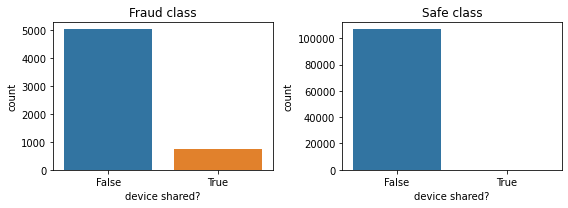

In [17]:
# Users share device? 
f_cond = fraud_df.device_id.value_counts() > 2
s_cond = safe_df.device_id.value_counts() > 2

countplot_side_by_side(f_cond, s_cond, 'device shared?')

In [18]:
#  Use device_id to assign country to 'invalid'

temp = data_df.device_id.value_counts()
temp_idx = temp.index
list_ = []
for i, t in enumerate(temp):
    if t > 1:
        list_.append(temp_idx[i])

# sample device_IP
data_df[['device_id', 'country', 'signup_time']].loc[data_df['device_id'] == 'QKNGBDKNZYROE']

# Result:
# Assumption is not correct!
# same device_id mapps to different users, countries
# possible reason: traveling, vpn, selling the device, etc.

,device_id,country,signup_time
89426,QKNGBDKNZYROE,United States,2015-07-07 05:21:52
101597,QKNGBDKNZYROE,Korea Republic of,2015-08-11 15:24:32


In [19]:
# New  feature: device_shared_count
# How manu users share the same device
data_df['device_shared_count'] = 0
data_df['device_shared_count'] = data_df.groupby(['device_id'])['device_shared_count'].transform('count')

data_df[['device_id', 'device_shared_count']].head(3)

,device_id,device_shared_count
149671,HZAKVUFTDOSFD,2
15611,XGQAJSOUJIZCC,1
73178,VCCTAYDCWKZIY,1


In [20]:
# New features: signup_month, and purchase_month
# converts dates to months
data_df['signup_month'] = data_df['signup_time'].dt.month
data_df['purchase_month'] = data_df['purchase_time'].dt.month

# New feature elapsed_time
# delay between signup and purchase in days
data_df['elapsed_time'] = (data_df['purchase_time'] - data_df['signup_time']).dt.days

# re-map the classes
safe_df = data_df.loc[data_df['class'] == 0]
fraud_df = data_df.loc[data_df['class'] == 1]

data_df[['signup_time', 'purchase_time', 'elapsed_time']].head(5)

,signup_time,purchase_time,elapsed_time
149671,2015-07-15 04:36:55,2015-09-10 14:17:56,57
15611,2015-01-24 12:29:58,2015-04-13 04:53:55,78
73178,2015-03-11 00:54:12,2015-04-05 12:23:49,25
84546,2015-01-07 13:19:17,2015-01-09 10:12:06,1
35978,2015-02-08 21:11:04,2015-04-09 14:26:10,59


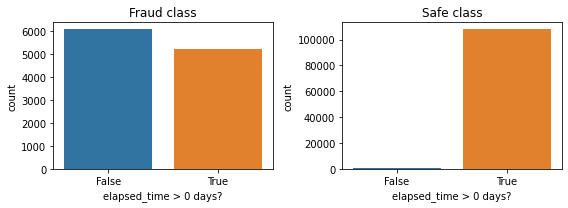

In [21]:
f_cond = fraud_df.elapsed_time > 0
s_cond = safe_df.elapsed_time > 0

countplot_side_by_side(f_cond, s_cond, 'elapsed_time > 0 days?')

In [22]:
# New  feature: delayed
# is the delay between sign up and purchase more than a day?

data_df['delayed'] = 2
data_df['delayed'] = data_df['elapsed_time'].apply(lambda x: 1 if x > 0 else 0)
data_df[['elapsed_time', 'delayed']].head(5)

,elapsed_time,delayed
149671,57,1
15611,78,1
73178,25,1
84546,1,1
35978,59,1


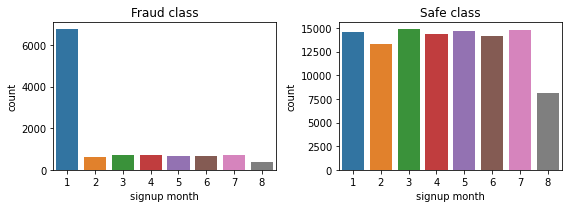

In [23]:
f_cond = fraud_df.signup_month
s_cond = safe_df.signup_month

countplot_side_by_side(f_cond, s_cond, 'signup month')

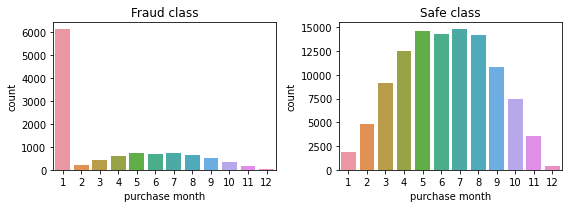

In [24]:
f_cond = fraud_df.purchase_month
s_cond = safe_df.purchase_month

countplot_side_by_side(f_cond, s_cond, 'purchase month')

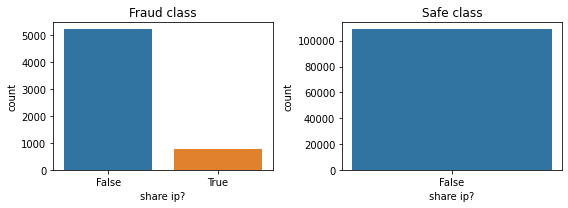

In [25]:
f_cond = fraud_df.ip_address.value_counts() > 1
s_cond = safe_df.ip_address.value_counts() > 1

countplot_side_by_side(f_cond, s_cond, 'share ip?')

In [26]:
# New  feature: ip_count
# How many users have the same ip?
data_df['ip_count'] = 0
data_df['ip_count'] = data_df.groupby(['ip_address'
                                      ])['ip_count'].transform('count')


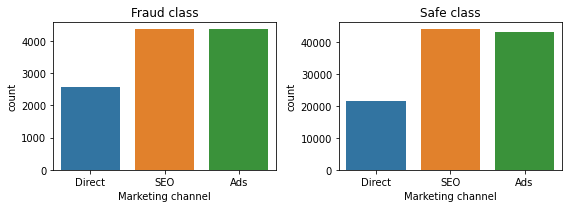

In [27]:
f_cond = fraud_df.source
s_cond = safe_df.source
countplot_side_by_side(f_cond, s_cond, 'Marketing channel')

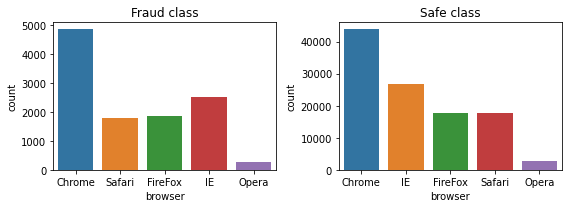

In [28]:
f_cond = fraud_df.browser
s_cond = safe_df.browser
countplot_side_by_side(f_cond, s_cond, 'browser')

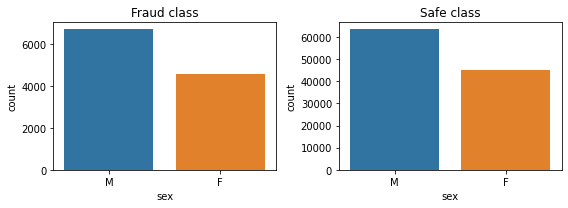

In [29]:
f_cond = fraud_df.sex
s_cond = safe_df.sex
countplot_side_by_side(f_cond, s_cond, 'sex')

In [30]:
# the age_category was initially used to group the user ages. It was removed because
# it did not add any value to the final performance of the model.In other words, the
# age category was more significant than this.
#
# Age to range
# # 18 to 26 = ‘0’
# # 27 to 36 = ‘1’
# # 37 to 46 = ‘2’
# # 47 to 56 = ‘3’
# # 57 to 66 = ‘4’
# # 67+: '5'

# data_df['age_category'] = pd.cut(
#     data_df.age, bins=[18, 27, 37, 47, 57, 67], labels=['0', '1', '2', '3', '4']
# )
# data_df['age_category'] = data_df['age_category'].cat.add_categories(5).fillna(5)

fraud class age: 18-66
safe  class age: 18-76


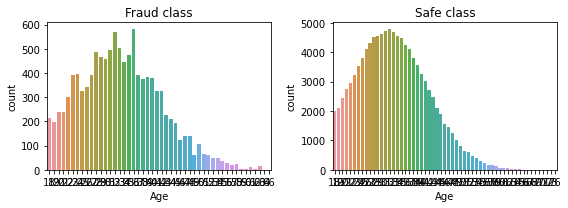

In [31]:
print('fraud class age: {}-{}'.format(fraud_df.age.min(), fraud_df.age.max()))
print('safe  class age: {}-{}'.format(safe_df.age.min(), safe_df.age.max()))

f_cond = fraud_df.age
s_cond = safe_df.age
countplot_side_by_side(f_cond, s_cond, 'Age')

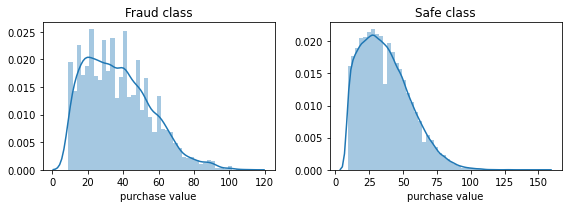

In [32]:
f_cond = fraud_df.purchase_value
s_cond = safe_df.purchase_value
countplot_side_by_side(f_cond, s_cond, 'purchase value', hist=1)

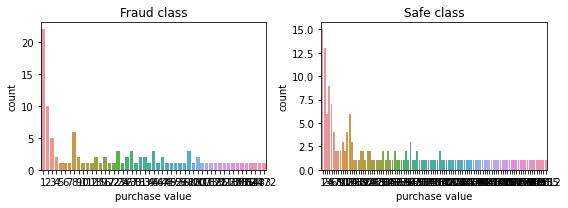

In [33]:
f_cond = fraud_df.country.value_counts()
s_cond = safe_df.country.value_counts()
countplot_side_by_side(f_cond, s_cond, 'purchase value')

In [34]:
# Convert categories tp numbers
data = data_df.copy()
for variable in ['country', 'sex', 'source', 'browser', 'age', 'device_id']:
    data[variable] = data[variable].factorize()[0]

data.head(3)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,device_shared_count,signup_month,purchase_month,elapsed_time,delayed,ip_count
149671,285108,2015-07-15 04:36:55,2015-09-10 14:17:56,31,0,0,0,0,0,2.818400e+09,0,0,2,7,9,57,1,1
15611,131009,2015-01-24 12:29:58,2015-04-13 04:53:55,31,1,1,1,1,1,3.251268e+09,0,1,1,1,4,78,1,1
73178,328855,2015-03-11 00:54:12,2015-04-05 12:23:49,16,2,0,1,0,2,2.727760e+09,0,0,1,3,4,25,1,1


# Machine Learning

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

In [36]:
def model_cost(fn, fp, tn, tp, name=''):
    """Approximates the gain and loss dollar value associated with a 
    model, and prints a report summary. The costs are:
    * false positive (false alarm): $8
    * false negative (Fraud Loss): average of the purchase_value = $36
    * true positive  (Prevented loss): $36
    * true negative  (Earned): $36
    * profit: (TP + TN) - (FN + FN )

    Arguments:
        fn (int): false negative
        fp (int): false positive
        tn (int): true negative
        tp (int): true positive

    Keyword Arguments:
        name (str): name of the model (default: {''})
    """
    fn_cost = fn * 36
    fp_cost = fp * 8
    tn_earned = tn * 36
    tp_prevented = tp * 36
    total_loss = fn_cost + fp_cost
    profit = tp_prevented + tn_earned - total_loss
    print(name + ' Summary\n=====================')
    print('False Alarm Cost: ${:,}'.format(fp_cost))
    print('Fraud Loss:       ${:,}'.format(fn_cost))
    print('Total   --------> ${:,}'.format(total_loss))
    print('Prevented:        ${:,}'.format(tp_prevented))
    print('Earned:           ${:,}'.format(tn_earned))
    print('Overall --------> ${:,}'.format(profit))


def plot_roc(fpr, tpr, roc_auc, title=''):
    """Plots ROC curve

    Arguments:
        fpr (array): false positive rate
        tpr (array): true positive rate
        roc_auc (obj): area under the curve

    Keyword Arguments:
        title (str): model name(default: '')
    """
    plt.figure()
    plt.plot(fpr,
             tpr,
             color='darkorange',
             lw=2,
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC Curve of '+ title)
    plt.legend(loc='lower right')


def plot_coefs(coefs, columns):
    """Plots feature importance

    Arguments:
        coefs (array): list of coefs from a trained model
        columns (obj): feature names
    """
    ticks_num = np.arange(len(columns))
    fig = plt.figure(figsize=(6, 3))
    ax = plt.subplot(111)
    sns.barplot(ticks_num, coefs)
    plt.title('Feature Importance')
    ax.set_xticks(ticks_num)
    ax.set_xticklabels(columns, rotation=90)

In [37]:
# data.head(1)

In [38]:
# # RUN TO CHECK
# # Convert categories tp numbers
# data = data_df.copy()
# for variable in ['country', 'sex', 'source', 'browser', 'age', 'device_id']:
#     data[variable] = data[variable].factorize()[0]

# safe_df = data.loc[data_df['class'] == 0]
# fraud_df = data.loc[data_df['class'] == 1]

# print (len(safe_df), len(fraud_df))

# fraud_df = fraud_df.sample(len(safe_df), random_state=10, replace=True )
# print (len(safe_df), len(fraud_df))

# data = pd.concat([safe_df, fraud_df])
# data = data.sample(frac=1).reset_index(drop=True)


In [39]:
features = [
    'purchase_value',
    'device_id',
    'source',
    'browser',
    'sex',
    'age',
    'country',
    'signup_month',
    'purchase_month',
    'elapsed_time',
    'device_shared_count',
    'delayed',
    'ip_count',
]
label = ['class']

X = data[features]
y = data[label].values.ravel()

scale = StandardScaler()
X_scaled = scale.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

print('Train size: ', X_train.shape)
print('Test size: ', X_test.shape)

Train size:  (96000, 13)
Test size:  (24000, 13)


## Model 01 - Logistic Regression (Baseline Model)

In [40]:
# initiate model
lr = LogisticRegression(max_iter=500, 
                        random_state=0, 
                        solver='liblinear', 
                        class_weight={0: 1, 1: 2})
print(lr)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 2}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


Accuracy: 0.946

               precision    recall  f1-score   support

           0       0.95      0.99      0.97     21773
           1       0.81      0.54      0.65      2227

    accuracy                           0.95     24000
   macro avg       0.88      0.77      0.81     24000
weighted avg       0.94      0.95      0.94     24000



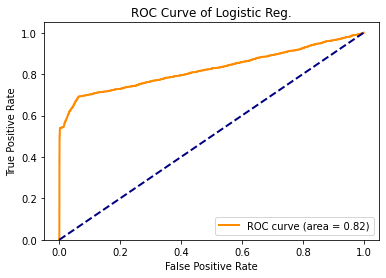

In [41]:
lr.fit(X_train, y_train)
y_hat = lr.predict(X_test)

print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_hat)))
print('\n', classification_report(y_test, y_hat))

# Extract probabilities and plot the ROC curve
y_proba = lr.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc, title='Logistic Reg.')

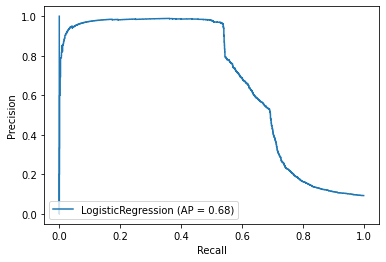

In [42]:
# Precision-recall curve
# More informative than ROC becuase of imbalanced data
plot_precision_recall_curve(lr, X_test, y_test);

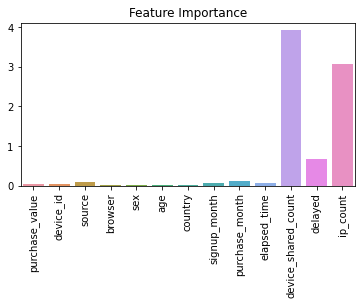

In [43]:
# Feature importance
plot_coefs(abs(lr.coef_.flatten()), X.columns)

In [44]:
# Model Summary in terms dollar cost
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
model_cost(fn, fp, tn, tp, 'LogisticReg.')

LogisticReg. Summary
False Alarm Cost: $2,280
Fraud Loss:       $36,540
Total   --------> $38,820
Prevented:        $43,632
Earned:           $773,568
Overall --------> $778,380


## Model 01A - Logistic Regression (Grid Search)

In [45]:
# initiate a model
lr_gs = LogisticRegression(class_weight={0:1, 1:2}, solver='liblinear', random_state=0)

# parameters to try
params_lr = {'max_iter':[20, 50, 100],
            'C': [0.0005, 0.0001, 0.001, 0.1, 1],
            'penalty': ['l1', 'l2'],
            }
# Grid search
gs = GridSearchCV(estimator=lr_gs,
                 param_grid=params_lr,
                 cv = 5,
                 n_jobs=-1)

gs.fit(X_train, y_train)

# Select best model and coefs
best_lr = gs.best_estimator_
coefs_lr = best_lr.coef_

print('Best CV params: ', gs.best_params_)
print('Number of selected features: {}/13'.format(np.count_nonzero(coefs_lr)))

Best CV params:  {'C': 0.0005, 'max_iter': 20, 'penalty': 'l1'}
Number of selected features: 2/13


Acc score: 0.952

               precision    recall  f1-score   support

           0       0.95      0.99      0.97     21773
           1       0.91      0.54      0.68      2227

    accuracy                           0.95     24000
   macro avg       0.93      0.77      0.83     24000
weighted avg       0.95      0.95      0.95     24000



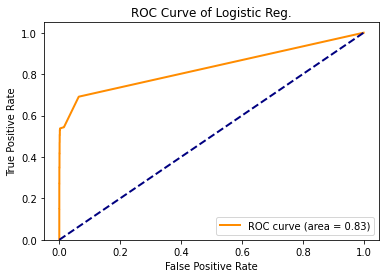

In [46]:
y_hat = best_lr.predict(X_test)

print('Acc score: {:.3f}'.format(accuracy_score(y_test, y_hat)))
print('\n', classification_report(y_test, y_hat))

y_proba = best_lr.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)

plot_roc(fpr, tpr, roc_auc, title = 'Logistic Reg.')

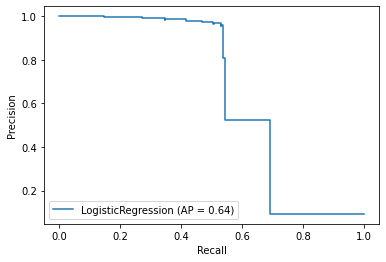

In [47]:
plot_precision_recall_curve(best_lr, X_test, y_test);

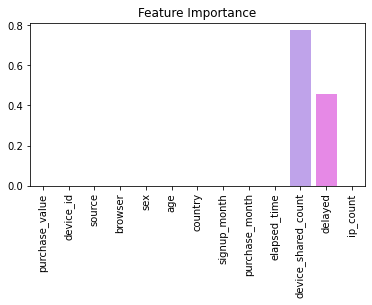

In [48]:
plot_coefs(abs(coefs_lr.flatten()), X.columns)

In [49]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
model_cost(fn, fp, tn, tp, 'LogisticReg(GrdSreach)')

LogisticReg(GrdSreach) Summary
False Alarm Cost: $944
Fraud Loss:       $36,936
Total   --------> $37,880
Prevented:        $43,236
Earned:           $779,580
Overall --------> $784,936


## Model 02 - Random Forest 

In [50]:
# initialize model
rf = RandomForestClassifier(random_state=0, class_weight={0:1, 1:2})
print(rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 2},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)


In [51]:
# model parameters
params_rf = {'n_estimators': [20, 50, 10],
             'max_depth':[2, 3, 4],
             'min_samples_leaf': [0.01, 0.1, 1],
             'max_features': ['log2', 'sqrt']   
            }

gs = GridSearchCV(estimator=rf,
                  param_grid=params_rf, 
                  cv = 5, 
                  n_jobs=-1)


# Sclaed features are used 
# RF Does not need scaled values though.
gs.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight={0: 1, 1: 2},
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                           

In [52]:
best_rf = gs.best_estimator_
coefs_rf = best_rf.feature_importances_

print('Best CV params: ', gs.best_params_)
print('Number of selected features: {}/13'.format(np.count_nonzero(coefs_rf)))

Best CV params:  {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 50}
Number of selected features: 13/13


Acc score: 0.957

               precision    recall  f1-score   support

           0       0.95      1.00      0.98     21773
           1       1.00      0.54      0.70      2227

    accuracy                           0.96     24000
   macro avg       0.98      0.77      0.84     24000
weighted avg       0.96      0.96      0.95     24000



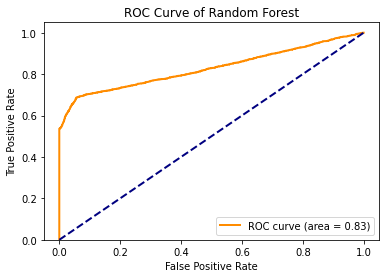

In [53]:
y_hat = best_rf.predict(X_test)

print('Acc score: {:.3f}'.format(accuracy_score(y_test, y_hat)))
print('\n', classification_report(y_test, y_hat))

y_proba = best_rf.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc, title='Random Forest')

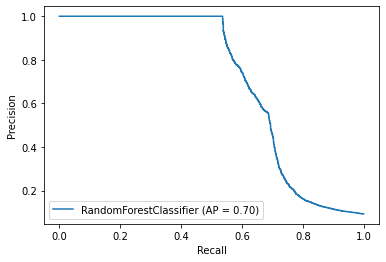

In [54]:
plot_precision_recall_curve(best_rf, X_test, y_test);

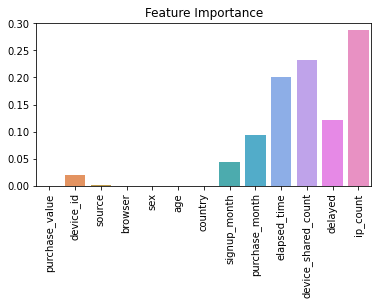

In [55]:
plot_coefs(coefs_rf.flatten(), X.columns)

In [56]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
model_cost(fn, fp, tn, tp, 'Random Forest')

Random Forest Summary
False Alarm Cost: $0
Fraud Loss:       $37,152
Total   --------> $37,152
Prevented:        $43,020
Earned:           $783,828
Overall --------> $789,696


# Model 03 - AdaBoost Classifier

In [57]:
#'{'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 50}
# Initial parameters are choosen based on the Random Forest grid search
dt = DecisionTreeClassifier(class_weight={0:1, 1:2}, max_depth=4, min_samples_leaf=1, random_state=0)
adb = AdaBoostClassifier(base_estimator=dt, n_estimators=50)
print(adb)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight={0: 1,
                                                                       1: 2},
                                                         criterion='gini',
                                                         max_depth=4,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                          

Acc score: 0.950

               precision    recall  f1-score   support

           0       0.96      0.99      0.97     21773
           1       0.84      0.57      0.68      2227

    accuracy                           0.95     24000
   macro avg       0.90      0.78      0.83     24000
weighted avg       0.95      0.95      0.95     24000



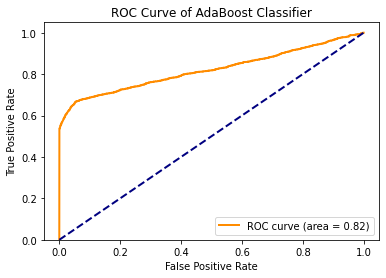

In [58]:
adb.fit(X_train, y_train)
y_hat = adb.predict(X_test)

print('Acc score: {:.3f}'.format(accuracy_score(y_test, y_hat)))
print('\n', classification_report(y_test, y_hat))

y_proba = adb.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc, title='AdaBoost Classifier')

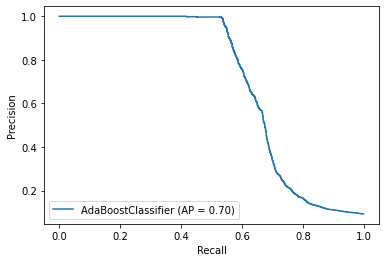

In [59]:
plot_precision_recall_curve(adb, X_test, y_test);

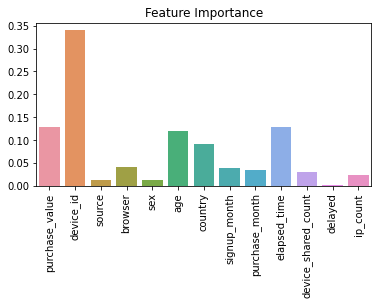

In [60]:
plot_coefs(adb.feature_importances_, X.columns)

In [61]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
model_cost(fn, fp, tn, tp, 'AdaBoost Classifier')

AdaBoost Classifier Summary
False Alarm Cost: $1,944
Fraud Loss:       $34,200
Total   --------> $36,144
Prevented:        $45,972
Earned:           $775,080
Overall --------> $784,908


# Model 04 - Voting Classifier

In [62]:
from sklearn.ensemble import VotingClassifier

lr_vc = LogisticRegression(class_weight={0: 1, 1: 2}, random_state=0)
rf_vc = RandomForestClassifier(class_weight={0: 1, 1:2},
                               max_depth=8,
                               max_features='log2',
                               min_samples_leaf=10,
                               n_estimators=50,
                               random_state=0,
                               n_jobs=-1)

dt_vc = DecisionTreeClassifier(random_state=0, 
                               class_weight={0: 1, 1:20})


ens_model = VotingClassifier(estimators=[('lr', lr_vc),
                                         ('rf', rf_vc)],
                             voting='soft'
                            )

# print (ens_model)

Accuracy: 0.955

               precision    recall  f1-score   support

           0       0.95      1.00      0.98     21773
           1       0.96      0.54      0.69      2227

    accuracy                           0.96     24000
   macro avg       0.96      0.77      0.83     24000
weighted avg       0.96      0.96      0.95     24000



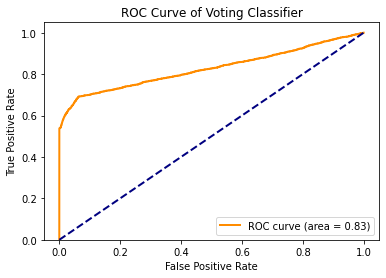

In [63]:
ens_model.fit(X_train, y_train)
y_hat = ens_model.predict(X_test)

print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_hat)))
print('\n', classification_report(y_test, y_hat))

y_proba = ens_model.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc, title='Voting Classifier')

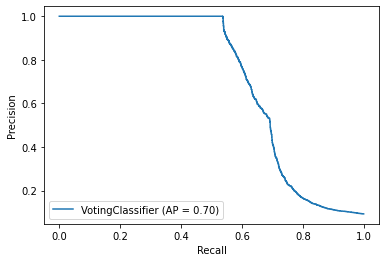

In [64]:
plot_precision_recall_curve(ens_model, X_test, y_test);

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
model_cost(fn, fp, tn, tp, 'Voting Classifier')

Voting Classifier Summary
False Alarm Cost: $408
Fraud Loss:       $36,936
Total   --------> $37,344
Prevented:        $43,236
Earned:           $781,992
Overall --------> $787,884


# Model 05 - Gradient Boosting Classifier

In [66]:
gbt = GradientBoostingClassifier(random_state=0)
print(gbt)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


In [67]:
params_gbt = {'n_estimators': [5, 10, 30],
             'max_depth':[ 3, 4],
             'min_samples_leaf': [0.1, 1],
             'max_features': ['log2', 'sqrt']   
            }

gs = GridSearchCV(estimator=gbt,
                  param_grid=params_gbt, 
                  cv = 5, 
                  n_jobs=-1)

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [68]:
best_gbt = gs.best_estimator_
coefs_gbt = best_gbt.feature_importances_

print('Best CV params: ', gs.best_params_)
print('Number of selected features: {}/13'.format(np.count_nonzero(coefs_gbt)))

Best CV params:  {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 10}
Number of selected features: 13/13


Acc score: 0.957

               precision    recall  f1-score   support

           0       0.95      1.00      0.98     21773
           1       1.00      0.54      0.70      2227

    accuracy                           0.96     24000
   macro avg       0.98      0.77      0.84     24000
weighted avg       0.96      0.96      0.95     24000



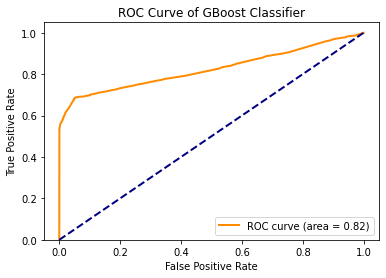

In [69]:
y_hat = best_gbt.predict(X_test)

print('Acc score: {:.3f}'.format(accuracy_score(y_test, y_hat)))
print('\n', classification_report(y_test, y_hat))

y_proba = best_gbt.predict_proba(X_test)[:, -1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
plot_roc(fpr, tpr, roc_auc, title='GBoost Classifier')

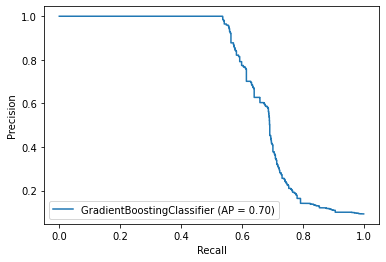

In [70]:
plot_precision_recall_curve(best_gbt, X_test, y_test);

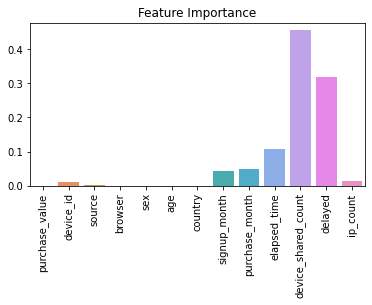

In [71]:
plot_coefs(coefs_gbt.flatten(), X.columns)

In [72]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
model_cost(fn, fp, tn, tp, 'GBoost Classifier')

GBoost Classifier Summary
False Alarm Cost: $0
Fraud Loss:       $37,152
Total   --------> $37,152
Prevented:        $43,020
Earned:           $783,828
Overall --------> $789,696


---
# Insights and Final Model

* Although in terms of accuracy score all models performed similarly (+94%), accuracy is not a good performance metric for this project. This is because the dataset is highly imbalanced and there are fewer positive classes compared to the negative classes.  As it was shown above, the associated error cost of the models were more than $37,000 for the test set.

* Since the dataset is unbalanced, both ROC and precision-recall(PR) curves are required to obtain an accurate view of the model performance. This is because the PR curve is focused on the correct prediction of the minority class.

* False Negative cost (\\$ 36 on average per transaction) **>>>** False Positive cost (\\$8 per transaction). Therefore, higher recall (more false flags) is more desirable, becuase most fraudulent transactions will be detected. 

* Comparing the PR curves of all models suggests both RandomForest and GradientBoost classifiers exhibited slightly better performance. AdaBoost had the highest recall rate, but its overall dollar value was less than the GradientB. classifier. **The GradientBoost classifiers is selected as the final model since it provided the highest dollar value.** This section investigates whether adjusting the precision/recall threshold will provide a more desirable outcome or not.



In [73]:
from sklearn.metrics import precision_recall_curve

y_score = best_gbt.predict_proba(X_test)[:,1]
p, r, thresh = precision_recall_curve(y_test, y_score)

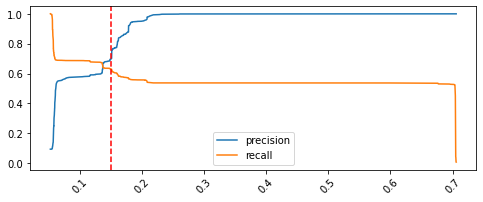

In [74]:
t = 0.15

plt.figure(figsize=(8,3))
plt.plot(thresh, p[:-1], label='precision')
plt.plot(thresh, r[:-1], label = 'recall')
plt.legend()
plt.xticks(rotation=45);
plt.axvline(x=t, ls='--', c='r');

In [75]:
y_hat_adjusted = [1 if y >= t else 0 for y in y_score]
print('\n', classification_report(y_test, y_hat_adjusted))



               precision    recall  f1-score   support

           0       0.96      0.97      0.97     21773
           1       0.70      0.63      0.66      2227

    accuracy                           0.94     24000
   macro avg       0.83      0.80      0.81     24000
weighted avg       0.94      0.94      0.94     24000



In [76]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
model_cost(fn, fp, tn, tp, 'Original')

Original Summary
False Alarm Cost: $0
Fraud Loss:       $37,152
Total   --------> $37,152
Prevented:        $43,020
Earned:           $783,828
Overall --------> $789,696


In [77]:
tn, fp, fn, tp = confusion_matrix(y_test, y_hat_adjusted).ravel()
model_cost(fn, fp, tn, tp, 'Adjusted')

Adjusted Summary
False Alarm Cost: $4,912
Fraud Loss:       $29,628
Total   --------> $34,540
Prevented:        $50,544
Earned:           $761,724
Overall --------> $777,728


# Unsupervise Learning 

In [78]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.metrics.cluster import homogeneity_score, silhouette_score


In [79]:
data_us = data.drop(columns=['user_id', 'signup_time', 'purchase_time'])
# data_us_np = data_us.values.astype(np.float)

X_us = data_us[features]
y_us = data_us[label]

scale = MinMaxScaler() 
# scale = StandardScaler()

X_us_scaled = scale.fit_transform(X_us)

X_train, X_test, y_train, y_test = train_test_split(X_us_scaled, y, test_size=0.2, random_state=0)

print (X_us_scaled.shape)
print (X_train.shape)

(120000, 13)
(96000, 13)


## K-means

In [80]:
clustno = range(1, 10)
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno]
score = [kmeans[i].fit(X_us_scaled).score(X_us_scaled) for i in range(len(kmeans))]


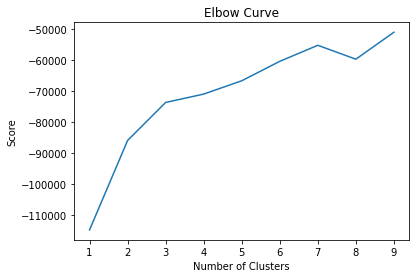

In [81]:
# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve');

In [82]:
kmeans = MiniBatchKMeans(n_clusters=2, random_state=0).fit(X_train)

X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_

dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

y_pred = np.array(dist)
y_pred[dist >= np.percentile(dist, 95)] = 1
y_pred[dist < np.percentile(dist, 95)] = 0

In [83]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, y_pred))

0.7560919390284144


In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     21739
           1       0.97      0.51      0.67      2261

    accuracy                           0.95     24000
   macro avg       0.96      0.76      0.82     24000
weighted avg       0.95      0.95      0.95     24000



## DBSCAN

In [85]:
# We need to find the smallest groups to assign them as outliers
dbsc = DBSCAN (eps=0.04, 
              metric = 'euclidean',
              min_samples=4,
              n_jobs=-1)

print (dbsc)

DBSCAN(algorithm='auto', eps=0.04, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=4, n_jobs=-1, p=None)


In [86]:
dbsc.fit(X_us)

y_hat = dbsc.labels_
n_clusters = len(set(y_hat)) - (1 if -1 in y else 0)
print('Estimated number of clusters: %d' % n_clusters)
print('Homogeneity: %0.3f' % homogeneity_score(y, y_hat))
# print('Silhouette Coefficient: %0.3f' % silhouette_score(X_us_scaled, y_hat))

Estimated number of clusters: 730
Homogeneity: 0.424


In [87]:
counts = np.bincount(y_hat[y_hat >= 0])
# print (counts)

In [88]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the counts of the smallest clusters only
counts[smallest_clusters]

array([4, 4, 4])

In [89]:
df = pd.DataFrame({'clust_n':y_hat,'y':y})

# Create a condition flagging fraud for the smallest clusters 
y_hat_dbsc = np.where((df['clust_n']==7) | (df['clust_n']==9) | (df['clust_n']==11), 1, 0)
roc_auc_score(y, y_hat_dbsc)

0.500976475810031

In [90]:
print(classification_report(y, y_hat_dbsc))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95    108735
           1       1.00      0.00      0.00     11265

    accuracy                           0.91    120000
   macro avg       0.95      0.50      0.48    120000
weighted avg       0.92      0.91      0.86    120000



In [91]:
tn, fp, fn, tp = confusion_matrix(y, y_hat_dbsc).ravel()
model_cost(fn, fp, tn, tp, 'Adjusted')

# Higher value because all dataset were used 

Adjusted Summary
False Alarm Cost: $0
Fraud Loss:       $404,748
Total   --------> $404,748
Prevented:        $792
Earned:           $3,914,460
Overall --------> $3,510,504


---
# Next Steps

* Using 'imblearn' library to create synthetic data to possibly improve the model performance.
* Adding more parameters to the model's grid search.